# Evolutionary Algorithms for Combinatorial Multi-Knapsack
## EA Functions
### Imports and Config

In [1]:
!pip install deap
import time, array, random, copy, math, sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import re
from deap import algorithms, base, benchmarks, tools, creator
from deap.benchmarks.tools import hypervolume
import seaborn
import itertools
from tqdm.notebook import tqdm

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

seaborn.set(style='whitegrid')
seaborn.set_context('notebook')
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout
fitness_calls = 0

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/NaturalKnapsack'


Mounted at /content/drive
/content/drive/MyDrive/NaturalKnapsack


### Instance Creation

In [5]:
def ws_split_int(lst):
    lst = re.split(r'\s+', lst)
    lst.pop()        #remove first empty character
    lst.pop(0)       #remove last empty character
    lst = [int(x) for x in lst]
    return lst
def instance_create(file_name, m, pop_size, num_gen, mut_rate, xover_rate, sample_num):
    with open(file_name) as f:
        lines = f.readlines()
    d = dict();
    d['ref'] = lines[0].strip()
    num_of_vars = d['num_of_vars'] = int(lines[1])
    d['profits'] = np.asarray(ws_split_int(lines[2]))
    combinations = [ws_split_int(i) for i in lines[3:num_of_vars+2]]
    combi_length = max(map(len, combinations))
    d['combinations'] = np.array([[0]*(combi_length-len(xi))+xi for xi in combinations])
    d['constraint_type'] = lines[int(num_of_vars)+3]
    weights = np.asarray(ws_split_int(lines[num_of_vars+5]))
    d['weights'] = weights    
    d['capacity'] = math.floor((0.8 * sum(weights)) / m)
    d['mut_rate'] = mut_rate
    d['xover_rate'] = xover_rate
    d['num_gen'] = num_gen
    d['pop_size'] = pop_size
    d['n_kp'] = m
    d['sample_num'] = sample_num
    return d
def develop_instance_list(m, num_gen, samples, mu_plus_lambda = False):
    files = os.listdir("./Project_Data_Sets")
    file_templates = ['jeu_100_25_', 'jeu_100_50_', 'jeu_100_75_', 'jeu_100_100_',
                      'jeu_200_25_', 'jeu_200_50_', 'jeu_200_75_', 'jeu_200_100_',
                      'jeu_300_25_', 'jeu_300_50_']
    instances = []
    if mu_plus_lambda:
        mutations = [.1, .2, .3, .4, .5, .6, .7, .8, .9]
        populations = [100, 150, 200,250]
        for i in range(samples):
            for file_template in file_templates:
                for mut_rate in mutations:
                    for pop_size in populations:
                        j = random.randint(1,10)
                        file_name = "./Project_Data_Sets/" + file_template + str(j) + ".txt"
                        instance = instance_create(file_name, m, pop_size, num_gen, mut_rate, 1-mut_rate, i+1)
                        instances.append(instance)
    else:
        populations = [100, 150, 200]
        xovers = [.2, .5, .8]
        mutations = [.05, .1, .15, .2]
        for i in range(samples):
            for file_template in file_templates:
                j = random.randint(1,10)
                file_name = "./Project_Data_Sets/" + file_template + str(j) + ".txt"
                for mut_rate in mutations:
                    for xover_rate in xovers:
                        for pop_size in populations:
                            instance = instance_create(file_name, m, pop_size, num_gen, mut_rate, xover_rate, i+1)
                            instances.append(instance)
    return instances

In [7]:
%time instances = develop_instance_list(3, 1000, 1, mu_plus_lambda = True)

Wall time: 8.17 s


### Population Generation, Fitness, Mutation, and Xover

In [8]:
def eval_fitness(individual, instance):
    n_kp = instance.get("n_kp")
    num_of_vars = instance.get("num_of_vars")
    profits = instance.get("profits")
    combinations = instance.get("combinations")
    constraint_type = instance.get("constraint_type")
    capacity = int(instance.get("capacity"))
    weights = instance.get("weights")
    knapsacks_weight = [0]*n_kp
    knapsacks_profit = [0]*n_kp
    
    for i in range(len(individual)):
        if individual[i] != 0 and individual[i] <= n_kp:
            knapsack = individual[i] - 1
            knapsacks_weight[knapsack] += weights[i]
            knapsacks_profit[knapsack] += profits[i]
            for j in range(i, len(individual)):
                if knapsack == individual[n_kp-j] - 1:
                    knapsacks_profit[knapsack] += combinations[i-1][n_kp-j-1]
    f1 = 0
    f2 = sum(knapsacks_weight)
    f3 = max(knapsacks_profit)+1
    for i in range(n_kp):
        if knapsacks_weight[i] > capacity:
            temp = knapsacks_profit[i] * (capacity / knapsacks_weight[i])
        else:
            temp = knapsacks_profit[i]
        f1 += temp
        if temp < f3:
            f3 = temp
    return f1, f2, f3

def uniform(low, m, n_kp):
    n = [0]*m
    for i in range(0,m):
        n[i] = random.randint(0,n_kp)
    return n

def favorite_child_xover(ind1, ind2):
    fit1 = ind1.fitness.values
    fit2 = ind2.fitness.values
    
    prob = fit1[0] / (fit1[0]+fit2[0])
    
    if fit1[0] > fit2[0]:
        prob = 1/prob
    
    size = min(len(ind1), len(ind2))
    
    for i in range(size):
        if random.random() > prob:
            ind1[i] = ind2[i]
            ind2[i] = ind1[i]
    return ind1, ind2

def mutation(x, n_kp):
    index = random.randrange(len(x))
    var = random.randint(0,n_kp)
    x[index] = var
    return x,



In [9]:
def varAnd(population, toolbox, cxpb, mutpb):
    offspring = [toolbox.clone(ind) for ind in population]

    # Apply crossover and mutation on the offspring
#     for i in range(1, len(offspring), 2):
#         if random.random() < cxpb:
#             offspring[i - 1], offspring[i] = toolbox.mate(offspring[i - 1],
#                                                           offspring[i])
#             del offspring[i - 1].fitness.values, offspring[i].fitness.values

    for i in range(len(offspring)):
        if random.random() < mutpb:
            offspring[i], = toolbox.mutate(offspring[i])
            del offspring[i].fitness.values

    return offspring
    
def eaSimple(population, toolbox, cxpb, mutpb, ngen, stats=None,
             halloffame=None, verbose=__debug__):
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is not None:
        halloffame.update(population)

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)
    
    # Begin the generational process
    counter = 0
    tmp = 0
    for gen in range(1, ngen + 1):
        # Select the next generation indivziduals
        offspring = toolbox.select(population, len(population))

        # Vary the pool of individuals
        offspring = varAnd(offspring, toolbox, cxpb, mutpb)

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Update the hall of fame with the generated individuals
        if halloffame is not None:
            halloffame.update(offspring)

        # Replace the current population by the offspring
        population[:] = offspring

        # Append the current generation statistics to the logbook
        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        
        max_fit = record.get("max")
        if max_fit == tmp:
            counter += 1
        else:
            counter = 0
        if counter == 10:
            break;
        
        tmp = max_fit
        
        if verbose:
            print(logbook.stream)

    return population, logbook

### Running EA

In [10]:
def run_ea(toolbox, stats=None, verbose=True):
    pop = toolbox.population(n=toolbox.pop_size)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("max", np.max)
    stats.register("avg", np.mean)
    population, logbook = eaSimple(pop, toolbox,
                                     cxpb=toolbox.cx_prob,
                                     mutpb=toolbox.mut_prob, 
                                     stats=stats, 
                                     ngen=toolbox.max_gen, 
                                     verbose=verbose)
    return population, logbook
def run_ea_mupluslambda(toolbox, stats = None, verbose = True):
    pop = toolbox.population(n=toolbox.pop_size)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("max", np.max)
    stats.register("avg", np.mean)
    population, logbook = algorithms.eaMuPlusLambda(pop, toolbox, 
                                                    mu=toolbox.pop_size,
                                                    lambda_=toolbox.pop_size,
                                                    cxpb=toolbox.cx_prob,
                                                    mutpb=toolbox.mut_prob,
                                                    stats=stats,
                                                    ngen=toolbox.max_gen,
                                                    verbose=verbose)
    return population, logbook
def run_ea_simple(toolbox, stats=None, verbose=True):
    pop = toolbox.population(n=toolbox.pop_size)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("max", np.max)
    stats.register("avg", np.mean)
    population, logbook = algorithms.eaSimple(pop, toolbox,
                                     cxpb=toolbox.cx_prob,
                                     mutpb=toolbox.mut_prob, 
                                     stats=stats, 
                                     ngen=toolbox.max_gen, 
                                     verbose=verbose)
    return population, logbook

### Single Execution Script

In [12]:
def execute_EA(instance, run_ea, verbose = False, save_figs = False):
    creator.create("FitnessMin", base.Fitness, weights=(1.0,-1.0, 1.0))
    creator.create("Individual", list, typecode='i', 
                   fitness=creator.FitnessMin)

    toolbox = base.Toolbox()
    num_kp = instance.get("n_kp")
    toolbox.register("evaluate", lambda x: eval_fitness(x, instance))
    BOUND_LOW, BOUND_UP = 0, instance.get("num_of_vars")
    toolbox.register("attr_float", uniform, BOUND_LOW, BOUND_UP, num_kp)
    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("mate", favorite_child_xover)
    toolbox.register("mutate", lambda x: mutation(x, num_kp),)
    toolbox.register("select", tools.selNSGA2)

    toolbox.pop_size = instance.get("pop_size")
    toolbox.max_gen = instance.get("num_gen")
    toolbox.mut_prob = instance.get("mut_rate")
    toolbox.cx_prob = instance.get("xover_rate")
    if verbose: 
        res,logbook = run_ea(toolbox)
    else:
        with HiddenPrints():
            res,logbook = run_ea(toolbox)
    fronts = [tools.emo.sortLogNondominated(res, len(res), first_front_only=True)]
    plot_colors = seaborn.color_palette("Set1", n_colors=10)
    fig = plt.figure(figsize=(15,10))
    ax1 = fig.add_subplot(2, 2, 1, projection='3d')
    ax2 = fig.add_subplot(2, 2, 2)
    ax3 = fig.add_subplot(2, 2, 3)
    ax4 = fig.add_subplot(2, 2, 4) #uncomment for subplots instead of separate plots 
    #fig1 = plt.figure(figsize=(15,10))
    #fig2 = plt.figure(figsize=(15,10))
    #fig3 = plt.figure(figsize=(15,10))
    #fig4 = plt.figure(figsize=(15,10))
    #ax1 = fig1.add_subplot(1, 1, 1, projection='3d')
    #ax2 = fig2.add_subplot(1, 1, 1)
    #ax3 = fig3.add_subplot(1, 1, 1)
    #ax4 = fig4.add_subplot(1, 1, 1)
    
    st_front = []
    hv = []
    ref = (0,sum(instance.get('weights')),0)
    for i,inds in enumerate(fronts):
        hv.append(hypervolume(inds, ref = ref))
        par = [toolbox.evaluate(ind) for ind in inds]
        df = pd.DataFrame(par)
        df = df.rename(columns={0: "f1", 1: "f2", 2: "f3"})
        ax1.scatter3D(df.f1, df.f2, df.f3, label='Front'+str(i+1), color=plot_colors[i])
        ax2.scatter(df.f1, df.f2, label='Front'+str(i+1), color=plot_colors[i])
        ax3.scatter(df.f1, df.f3, label='Front'+str(i+1), color=plot_colors[i])
        ax4.scatter(df.f2, df.f3, label='Front'+str(i+1), color=plot_colors[i])
        st_front.append(df)
    ax1.legend();ax2.legend();ax3.legend();ax4.legend()
    ax1.set_xlabel('$f_1(\mathbf{x})$');ax1.set_ylabel('$f_2(\mathbf{x})$');ax1.set_zlabel('$f_3(\mathbf{x})$')
    ax2.set_xlabel('$f_1(\mathbf{x})$');ax2.set_ylabel('$f_2(\mathbf{x})$')
    ax3.set_xlabel('$f_1(\mathbf{x})$');ax3.set_ylabel('$f_3(\mathbf{x})$')
    ax4.set_xlabel('$f_2(\mathbf{x})$');ax4.set_ylabel('$f_3(\mathbf{x})$')

    #fig1.savefig('temp1.png', dpi=fig1.dpi)
    #fig2.savefig('temp2.png', dpi=fig2.dpi)
    #fig3.savefig('temp3.png', dpi=fig3.dpi)
    #fig4.savefig('temp4.png', dpi=fig4.dpi)
    if save_figs:
        name_parameters = [instance.get('ref'),
                           str(instance.get('sample_num')),
                           str(instance.get('n_kp')),
                           str(int(instance.get('mut_rate')*100)),
                           str(int(instance.get('xover_rate')*100)),
                           str(instance.get('pop_size')),
                           str(instance.get('num_gen')),
                           str(run_ea.__name__).replace('run_ea_', '')]
        fig_name = './plots/'+ '_'.join(name_parameters) + ".png"
        fig.savefig(fig_name, dpi = fig.dpi)
        plt.close(fig)
    stat_dict = {'instance_name': instance.get('ref'),
             'sample_num': instance.get('sample_num'),
             'xover_rate': instance.get('xover_rate'),
             'mut_rate': instance.get('mut_rate'),
             'pop_size': instance.get('pop_size'),
             'num_gen': instance.get('num_gen'),
             'n_kp': instance.get('n_kp'),
             'mean_f1' : np.mean(st_front[0].f1),
             'median_f1' : np.median(st_front[0].f1),
             'variance_f1': np.var(st_front[0].f1), 
             'sample_size': len(st_front[0].f1), 
             'min_f1': min(st_front[0].f1),
             'max_f1': max(st_front[0].f1),
             'mean_f2' : np.mean(st_front[0].f2),
             'median_f2' : np.median(st_front[0].f2),
             'variance_f2': np.var(st_front[0].f2),
             'sample_size': len(st_front[0].f2),
             'min_f2': min(st_front[0].f2),
             'max_f2': max(st_front[0].f2),
             'mean_f3' : np.mean(st_front[0].f3),
             'median_f3' : np.median(st_front[0].f3),
             'variance_f3': np.var(st_front[0].f3),
             'sample_size': len(st_front[0].f3),
             'min_f3': min(st_front[0].f3),
             'max_f3': max(st_front[0].f3),
             'hypervolume':hv[0]}
    return res,logbook, fronts[0], stat_dict

### Fitness Landscape Analysis

In [13]:
def fitness_binary(individual, instance):
    f1_fit = [0]
    f2_fit = [0]
    f3_fit = [0]

    landscape_f1 = []
    landscape_f2 = []
    landscape_f3 = []

    for i in range(0,1000):
        fitness = eval_fitness(individual, instance)
        f1_fit.append(fitness[0])
        f2_fit.append(fitness[1])
        f3_fit.append(fitness[2])

        if 1 - f1_fit[-2]/f1_fit[-1] > 0.005:
            landscape_f1.append(1)
        elif 1 - f1_fit[-2]/f1_fit[-1] < -0.005:
            landscape_f1.append(-1)
        else:
            landscape_f1.append(0)

        if 1 - f2_fit[-2]/f2_fit[-1] > 0.005:
            landscape_f2.append(1)
        elif 1 - f2_fit[-2]/f2_fit[-1] < -0.005:
            landscape_f2.append(-1)
        else:
            landscape_f2.append(0)

        if 1 - f3_fit[-2]/f3_fit[-1] > 0.005:
            landscape_f3.append(1)
        elif 1 - f3_fit[-2]/f3_fit[-1] < -0.005:
            landscape_f3.append(-1)
        else:
            landscape_f3.append(0)

        individual = mutation(individual, 3)

    f1_fit.pop(0)
    f2_fit.pop(0)
    f3_fit.pop(0)
    landscape_f1.pop(0)
    landscape_f2.pop(0)
    landscape_f3.pop(0)
    
    return landscape_f1, landscape_f2, landscape_f3

def landscape_eval(landscape):
    count_01 = count_0m1 = count_10 = count_1m1 = count_m10 = count_m11 = 0
    H_f = 0
    for i in range(len(landscape)-1):
        if landscape[i] != landscape[i+1]:
            if landscape[i] == 0 and landscape[i+1] == 1:
                count_01 += 1
            if landscape[i] == 0 and landscape[i+1] == -1:
                count_0m1 += 1
            if landscape[i] == 1 and landscape[i+1] == 0:
                count_10 += 1
            if landscape[i] == 1 and landscape[i+1] == -1:
                count_1m1 += 1
            if landscape[i] == -1 and landscape[i+1] == 0:
                count_m10 += 1
            if landscape[i] == -1 and landscape[i+1] == 1:
                count_m11 += 1

    count_rug = [count_01] + [count_0m1] + [count_10] + [count_1m1] + [count_m10] + [count_m11]

    for i in range(len(count_rug)):
        P_pq = count_rug[i] / len(landscape)
        if P_pq != 0:
            H_f += -P_pq * math.log(P_pq, 6)
    return H_f

file_templates = ['jeu_100_25_1.txt', 'jeu_100_50_1.txt', 'jeu_100_75_1.txt', 'jeu_100_100_1.txt',
                      'jeu_200_25_1.txt', 'jeu_200_50_1.txt', 'jeu_200_75_1.txt', 'jeu_200_100_1.txt',
                      'jeu_300_25_1.txt', 'jeu_300_50_1.txt']

fx_land = []
for j in range(0,31):
    for i in range(len(file_templates)):
        individual = uniform(BOUND_LOW, BOUND_UP, 3)
        file = file_templates[i]
        instance = instance_create("./Project_Data_Sets/" + file, 3, 20, 50, .2, .8, 0)
        landscape_f1, landscape_f2, landscape_f3 = fitness_binary(individual, instance)

        H_f1 = landscape_eval(landscape_f1)
        H_f2 = landscape_eval(landscape_f2)
        H_f3 = landscape_eval(landscape_f3)

        density = file[8:file.find("_1.txt")]

        fx_land.append([file, instance.get("num_of_vars"), density, H_f1, H_f2, H_f3])

        print(file)
#     print("For f1: H(e) = " + str(H_f1))
#     print("For f2: H(e) = " + str(H_f2))
#     print("For f3: H(e) = " + str(H_f3))
df_land = pd.DataFrame(fx_land, columns=['file_name','num_var','density','f1', 'f2', 'f3'], index=None)
df_land.sort_values(by=['file_name'], inplace=True)
df_land.to_csv("df_landscape.csv", index=False)
print(df_land)

NameError: name 'BOUND_LOW' is not defined

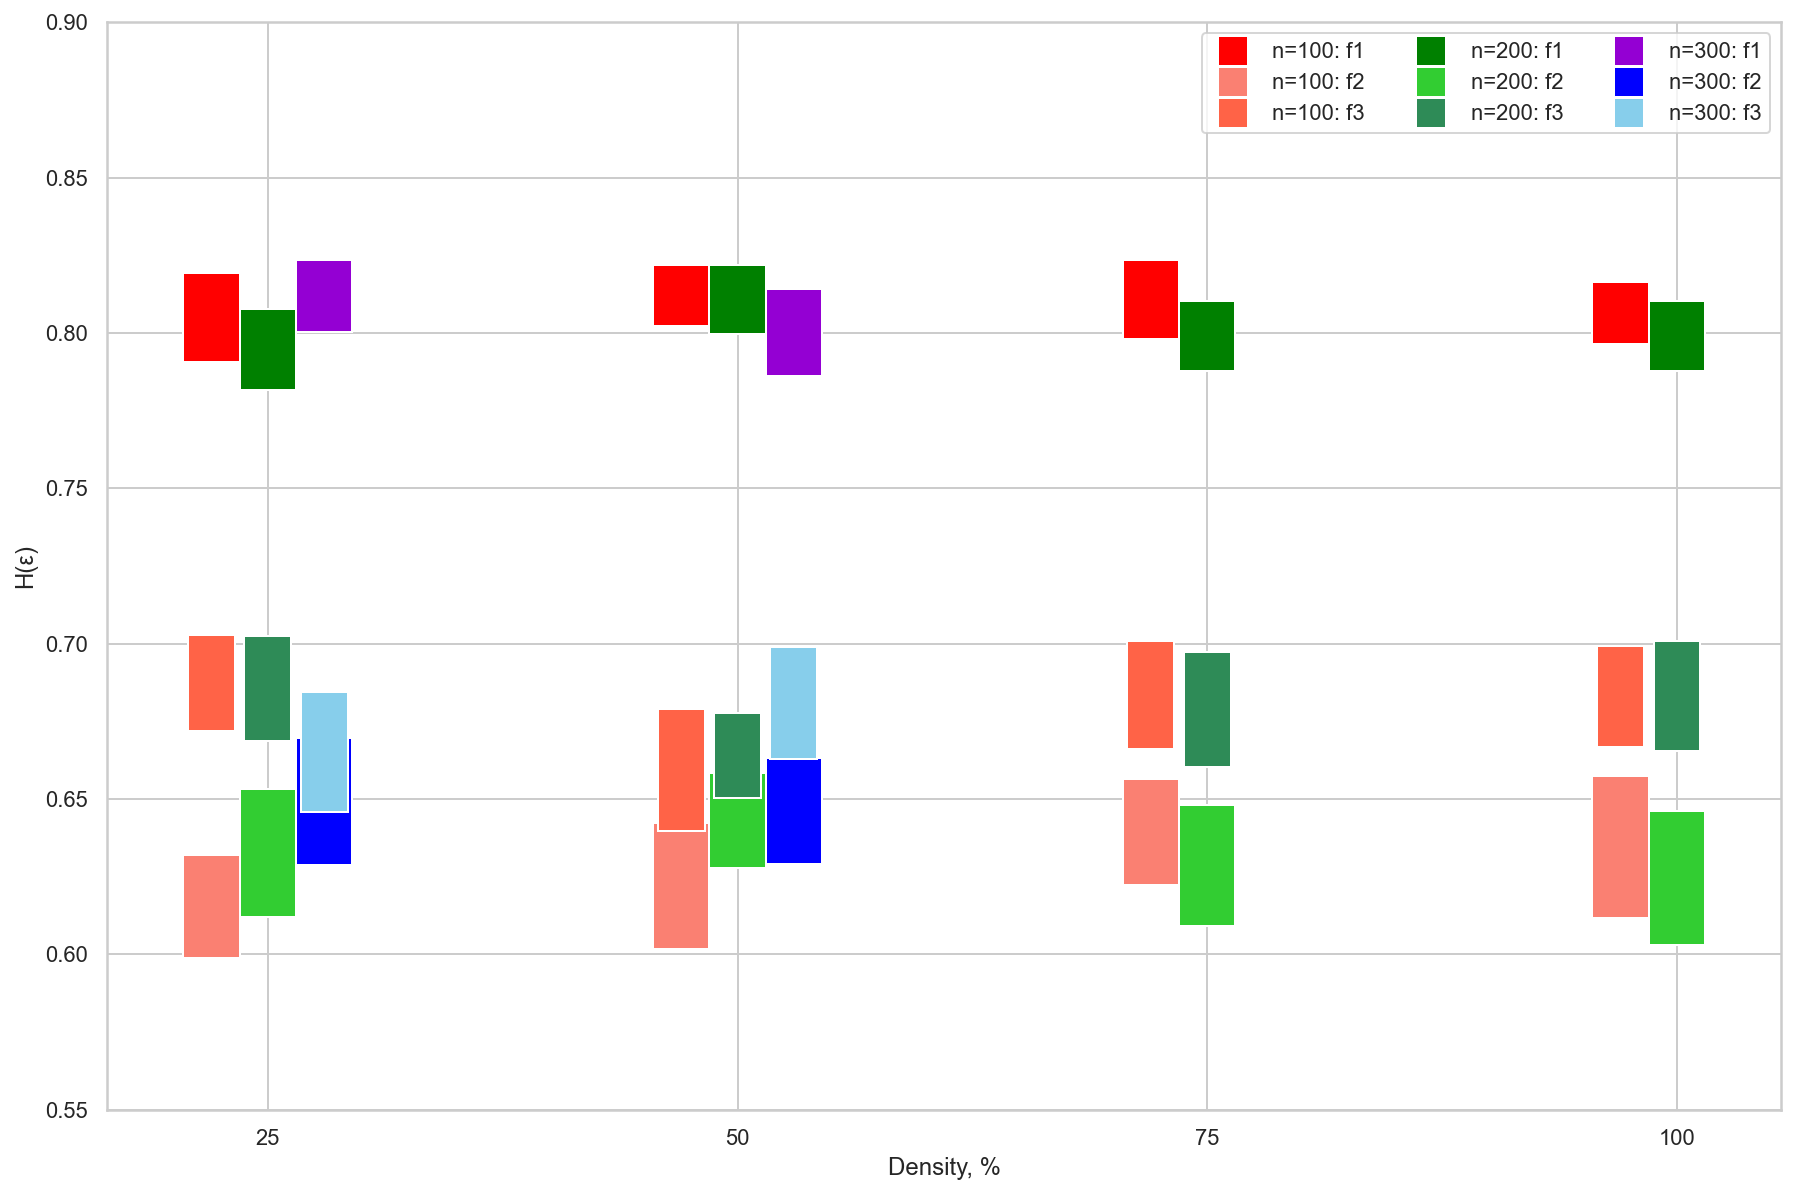

In [384]:
from matplotlib.lines import Line2D
from scipy.stats import norm

df = pd.read_csv('df_landscape.csv')

num_var = df["num_var"].tolist()
density = df["density"].tolist()
f1 = df["f1"].tolist()
f2 = df["f2"].tolist()
f3 = df["f3"].tolist()

plt.figure(figsize=(15,10))
ind = [25,50,75,100]*3
width = 3.0

#n = 100
for i in range(0,4):
    mu_f1, std_f1 = norm.fit(f1[i*31:((i+1)*31)])
    mu_f2, std_f2 = norm.fit(f2[i*31:((i+1)*31)])
    mu_f3, std_f3 = norm.fit(f3[i*31:((i+1)*31)])
    plt.bar(ind[i]-3, std_f1*2, width, bottom=mu_f1-std_f1, color='red', label='n=100')
    plt.bar(ind[i]-3, std_f2*2, width, bottom=mu_f2-std_f2, color='salmon', label='n=100')
    plt.bar(ind[i]-3, std_f3*2, width=2.5, bottom=mu_f3-std_f3, color='tomato', label='n=100')

#n = 200
for i in range(4,8):
    mu_f1, std_f1 = norm.fit(f1[i*31:((i+1)*31)])
    mu_f2, std_f2 = norm.fit(f2[i*31:((i+1)*31)])
    mu_f3, std_f3 = norm.fit(f3[i*31:((i+1)*31)])
    plt.bar(ind[i], std_f1*2, width, bottom=mu_f1-std_f1, color='green')
    plt.bar(ind[i], std_f2*2, width, bottom=mu_f2-std_f2, color='limegreen')
    plt.bar(ind[i], std_f3*2, width=2.5, bottom=mu_f3-std_f3, color='seagreen')
#n = 300
for i in range(8,10):
    mu_f1, std_f1 = norm.fit(f1[i*31:((i+1)*31)])
    mu_f2, std_f2 = norm.fit(f2[i*31:((i+1)*31)])
    mu_f3, std_f3 = norm.fit(f3[i*31:((i+1)*31)])
    plt.bar(ind[i]+3, std_f1*2, width, bottom=mu_f1-std_f1, color='darkviolet')
    plt.bar(ind[i]+3, std_f2*2, width, bottom=mu_f2-std_f2, color='blue')
    plt.bar(ind[i]+3, std_f3*2, width=2.5, bottom=mu_f3-std_f3, color='skyblue') 


legend_elements = [Line2D([0], [0], marker='s', color='w', label='n=100: f1',
                          markerfacecolor='red', markersize=15),
                   Line2D([0], [0], marker='s', color='w', label='n=100: f2',
                          markerfacecolor='salmon', markersize=15),
                   Line2D([0], [0], marker='s', color='w', label='n=100: f3',
                          markerfacecolor='tomato', markersize=15),
                   Line2D([0], [0], marker='s', color='w', label='n=200: f1',
                          markerfacecolor='green', markersize=15),
                   Line2D([0], [0], marker='s', color='w', label='n=200: f2',
                          markerfacecolor='limegreen', markersize=15),
                   Line2D([0], [0], marker='s', color='w', label='n=200: f3',
                          markerfacecolor='seagreen', markersize=15),
                   Line2D([0], [0], marker='s', color='w', label='n=300: f1',
                          markerfacecolor='darkviolet', markersize=15),
                   Line2D([0], [0], marker='s', color='w', label='n=300: f2',
                          markerfacecolor='blue', markersize=15),
                   Line2D([0], [0], marker='s', color='w', label='n=300: f3',
                          markerfacecolor='skyblue', markersize=15)
                   
                   ]
plt.ylim(0.55,0.9)
x = [25,50,75,100]
plt.xticks(x)
plt.xlabel("Density, %")
plt.ylabel("H(ε)")
plt.legend(handles=legend_elements, ncol=3)
plt.savefig('fit_land.jpg')
plt.show()

## Running and Testing
### Single Execution

In [ ]:
#file_name, m, pop_size, num_gen, mut_rate, xover_rate, sample_num
instance = instance_create('Project_Data_Sets/jeu_300_25_1.txt', 3, 20, 50, .2, .8, 0)
%time res2, logbook2, front2, stats2 = execute_EA(instance, run_ea_mupluslambda ,verbose = True, save_figs = True)

gen	nevals	max    	avg    
0  	20    	61887.6	24947.3
1  	20    	61887.6	25346.3
2  	20    	64196.1	25441  
3  	20    	64196.1	25633.9
4  	20    	64196.1	25562.9
5  	20    	64196.1	25181.6
6  	20    	69005.3	25962.9
7  	20    	69005.3	25894.6
8  	20    	69005.3	25366.9
9  	20    	69912.3	26145.8
10 	20    	69912.3	26205.9
11 	20    	69912.3	26546.8
12 	20    	70509.7	25739.4
13 	20    	70509.7	26535.6
14 	20    	70509.7	26864  
15 	20    	70545.9	25853.6
16 	20    	70545.9	26595.4
17 	20    	70545.9	26430.1
18 	20    	70545.9	26281  
19 	20    	70545.9	27125  
20 	20    	70545.9	26822.3
21 	20    	70545.9	27111.9
22 	20    	70545.9	26839  
23 	20    	70545.9	27073.2
24 	20    	70880.6	26843  
25 	20    	70880.6	27421.3
26 	20    	70880.6	26949.1
27 	20    	70880.6	26772.4
28 	20    	70880.6	26737.9
29 	20    	70880.6	26803.5
30 	20    	70880.6	26556.5
31 	20    	70880.6	26913.8
32 	20    	70880.6	26939.1
33 	20    	70880.6	26846.6
34 	20    	70880.6	27047.7
35 	20    	70880.6	27130.6
3

In [15]:
def multiple_runs(instances, run_ea):
    results = []
    fronts = []
    for i in tqdm(range(len(instances))):
        res, logbook, front, stats = execute_EA(instances[i], run_ea ,verbose = False, save_figs = True)
        results.append(stats)
        fronts.append(front)
    return pd.DataFrame(results), fronts

In [ ]:
# m, num_gen, samples, mu_plus_lambda = False

list1 = instance_list[:60]
results1, fronts1 = multiple_runs(list1, run_ea_mupluslambda)
pd.DataFrame(results1).to_csv('3kp_200GenRun1.csv')

  0%|          | 0/60 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [ ]:
instance_list = develop_instance_list(3, 200, 1, mu_plus_lambda = True)

list2 = instance_list[60:120]
results2, fronts2 = multiple_runs(list2, run_ea_mupluslambda)
pd.DataFrame(results2).to_csv('3kp_200GenRun2.csv')

  0%|          | 0/60 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [ ]:
list3 = instance_list[120:180]
results3, fronts3 = multiple_runs(list3, run_ea_mupluslambda)
pd.DataFrame(results3).to_csv('3kp_200GenRun3.csv')

  0%|          | 0/60 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [ ]:
list4 = instance_list[180:270]
results4, fronts4 = multiple_runs(list4, run_ea_mupluslambda)
pd.DataFrame(results4).to_csv('3kp_200GenRun4.csv')

  0%|          | 0/90 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [ ]:
list5 = instance_list[270:300]
results5, fronts5 = multiple_runs(list5, run_ea_mupluslambda)
pd.DataFrame(results5).to_csv('3kp_200GenRun5.csv')

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [ ]:
instance_list = develop_instance_list(3, 200, 1, mu_plus_lambda = True)
list6 = instance_list[300:330]
results6, fronts6 = multiple_runs(list6, run_ea_mupluslambda)
pd.DataFrame(results6).to_csv('3kp_200GenRun6.csv')

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [ ]:
list7 = instance_list[330:]
results7, fronts7 = multiple_runs(list7, run_ea_mupluslambda)
pd.DataFrame(results7).to_csv('3kp_200GenRun7.csv')

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [9]:
# m, num_gen, samples, mu_plus_lambda = False
instance_list = develop_instance_list(5, 200, 1, mu_plus_lambda = True)


In [ ]:
list1 = instance_list[:60]
results1, fronts1 = multiple_runs(list1, run_ea_mupluslambda)
pd.DataFrame(results1).to_csv('5kp_200GenRun1.csv')

  0%|          | 0/60 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [ ]:
list2 = instance_list[60:120]
results2, fronts2 = multiple_runs(list2, run_ea_mupluslambda)
pd.DataFrame(results2).to_csv('5kp_200GenRun2.csv')

  0%|          | 0/60 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [ ]:
list3 = instance_list[120:180]
results3, fronts3 = multiple_runs(list3, run_ea_mupluslambda)
pd.DataFrame(results3).to_csv('5kp_200GenRun3.csv')

  0%|          | 0/60 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [ ]:
list4 = instance_list[180:240]
results4, fronts4 = multiple_runs(list4, run_ea_mupluslambda)
pd.DataFrame(results4).to_csv('5kp_200GenRun4.csv')

  0%|          | 0/60 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [ ]:
list5 = instance_list[240:300]
results5, fronts5 = multiple_runs(list5, run_ea_mupluslambda)
pd.DataFrame(results5).to_csv('5kp_200GenRun5.csv')

  0%|          | 0/60 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [ ]:
list6 = instance_list[300:330]
results6, fronts6 = multiple_runs(list6, run_ea_mupluslambda)
pd.DataFrame(results6).to_csv('5kp_200GenRun6.csv')

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [ ]:
list7 = instance_list[330:360]
results7, fronts7 = multiple_runs(list7, run_ea_mupluslambda)
pd.DataFrame(results7).to_csv('5kp_200GenRun7.csv')

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [ ]:
instance_list = develop_instance_list(10, 200, 1, mu_plus_lambda = True)

In [16]:
instance_list = develop_instance_list(10, 200, 1, mu_plus_lambda = True)
list1 = instance_list[:60]
results1, fronts1 = multiple_runs(list1, run_ea_mupluslambda)
pd.DataFrame(results1).to_csv('10kp_200GenRun1.csv')

  0%|          | 0/60 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [17]:
list2 = instance_list[60:120]
results2, fronts2 = multiple_runs(list2, run_ea_mupluslambda)
pd.DataFrame(results2).to_csv('10kp_200GenRun2.csv')

  0%|          | 0/60 [00:00<?, ?it/s]

In [ ]:
instance_list = develop_instance_list(10, 200, 1, mu_plus_lambda = True)
list3 = instance_list[120:180]
results3, fronts3 = multiple_runs(list3, run_ea_mupluslambda)
pd.DataFrame(results3).to_csv('10kp_200GenRun3.csv')

  0%|          | 0/60 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [ ]:
instance_list = develop_instance_list(10, 200, 1, mu_plus_lambda = True)
list4 = instance_list[180:240]
results4, fronts4 = multiple_runs(list4, run_ea_mupluslambda)
pd.DataFrame(results4).to_csv('10kp_200GenRun4.csv')

In [ ]:
instance_list = develop_instance_list(10, 200, 1, mu_plus_lambda = True)
list5 = instance_list[240:300]
results5, fronts5 = multiple_runs(list5, run_ea_mupluslambda)
pd.DataFrame(results5).to_csv('10kp_200GenRun5.csv')

  0%|          | 0/60 [00:00<?, ?it/s]

In [ ]:
list6 = instance_list[300:330]
results6, fronts6 = multiple_runs(list6, run_ea_mupluslambda)
pd.DataFrame(results6).to_csv('5kp_200GenRun6.csv')

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [ ]:
list7 = instance_list[330:360]
results7, fronts7 = multiple_runs(list7, run_ea_mupluslambda)
pd.DataFrame(results7).to_csv('10kp_200GenRun7.csv')

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
